In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
plt.style.use('seaborn')

# 讀入資料

In [2]:
Fed_Fund_rate_collection = pd.read_csv(
    '/Users/andy/Desktop/RA project for professor Yueh/2020:3 - 2020:6/New Version (Different T)/data/Fed_fund_rate_fitted_result.csv'
)

sigma_r_square_collection = pd.read_excel(
    '/Users/andy/Desktop/RA project for professor Yueh/2020:3 - 2020:6/New Version (Different T)/data/Calibration_result_from Leo-Numerix(arranged).xlsx'
)

phi_T_collection = pd.read_csv(
    '/Users/andy/Desktop/RA project for professor Yueh/2020:3 - 2020:6/New Version (Different T)/data/phi(T1, T2).csv'
)

sigma_s_square_collection = pd.read_csv(
    '/Users/andy/Desktop/RA project for professor Yueh/2020:3 - 2020:6/New Version (Different T)/data/Sigma s square.csv'
)

T1_T2_SOFR_rate = pd.read_excel(
    'T1_T2_SOFR_rate.xlsx'
)

In [3]:
Fed_Fund_rate_collection.head()

,Required Tenor,Zero_Rate_Cubic_spline,Discount_Factor_Cubic_spline,Zero_Rate_NS,Discount_Factor_NS,Zero_Rate_NSS,Discount_Factor_NSS
0,0.011111,0.015773,0.999825,0.016425,0.999818,0.014951,0.999834
1,0.083333,0.016100,0.998659,0.016218,0.998649,0.014933,0.998756
2,0.169444,0.016044,0.997285,0.015982,0.997296,0.014911,0.997477
3,0.252778,0.015950,0.995976,0.015763,0.996023,0.014890,0.996243
4,0.338889,0.015822,0.994653,0.015548,0.994745,0.014869,0.994974


In [4]:
sigma_r_square_collection.head()

,Unnamed: 0,0.012,0.01,0.03,0.05
0,1m,0.006251,0.006235,0.006517,0.006807
1,3m,0.005341,0.005331,0.005502,0.005677
2,6m,0.005041,0.005035,0.005137,0.005239
3,1y,0.004934,0.004928,0.005021,0.005114
4,2y,0.006674,0.006625,0.007443,0.008246


In [5]:
phi_T_collection.head()

,Required Tenor,"phi(T1, T2)"
0,0.011111,0.000175
1,0.083333,0.001167
2,0.169444,0.001377
3,0.252778,0.001314
4,0.338889,0.001331


In [6]:
sigma_s_square_collection.head()

,Required Tenor,estimated_sigma_s_square
0,0.083333,0.322256
1,0.169444,0.346212
2,0.252778,0.384636
3,0.338889,0.557555
4,0.422222,0.496385


In [7]:
T1_T2_SOFR_rate.head()

,T1,T2,Type of futures,SOFR futures rate
0,0.011111,0.083333,1,1.590
1,0.083333,0.169444,1,1.560
2,0.169444,0.252778,1,1.535
3,0.252778,0.338889,1,1.480
4,0.338889,0.422222,1,1.435


# 整理資料

In [8]:
sigma_r_square_collection.rename(columns={'Unnamed: 0': 'Maturity'}, inplace=True)
sigma_r_square_collection.index = sigma_r_square_collection.Maturity
sigma_r_square_collection.drop(columns='Maturity', inplace=True)

# 只會用到第一個值，因為是從0開始，其他後面的要用bootstrap算出來
sigma_r_square_collection.head()

,0.012,0.010,0.030,0.050
Maturity,,,,
1m,0.006251,0.006235,0.006517,0.006807
3m,0.005341,0.005331,0.005502,0.005677
6m,0.005041,0.005035,0.005137,0.005239
1y,0.004934,0.004928,0.005021,0.005114
2y,0.006674,0.006625,0.007443,0.008246


In [9]:
# 把T1_T2_SOFR_rate和sigma_s_square_collection依據Required Tenor合併起來
# T1_T2_SOFR_rate含有3M小於1年的部分，而sigma_s_square_collection已經是整理過的Required Tenor
# 所以依據sigma_s_square_collection的Required Tenor去merge就不會有問題
# 這裡因為會有浮點數的問題，所以先建立一個column當作merge的key，直接對要merge的Tenor四捨五入到小數點後5位
# 照樣就可以確保兩邊會對的起來，不會有浮點數問題
T1_T2_SOFR_rate['key_for_merge'] = round(
    T1_T2_SOFR_rate['T2'], 5
)

sigma_s_square_collection['key_for_merge'] = round(
    sigma_s_square_collection['Required Tenor'], 5
)

sigma_s_square_collection = sigma_s_square_collection.merge(
    T1_T2_SOFR_rate,
    on='key_for_merge'
)

# 去除剛剛用來merge的key
sigma_s_square_collection.drop(columns=['key_for_merge'], inplace=True)

# 將SOFR futures rate由百分比轉成小數點
sigma_s_square_collection['SOFR futures rate'] = (
    sigma_s_square_collection['SOFR futures rate'] / 100
)

sigma_s_square_collection.head()

,Required Tenor,estimated_sigma_s_square,T1,T2,Type of futures,SOFR futures rate
0,0.083333,0.322256,0.011111,0.083333,1,0.01590
1,0.169444,0.346212,0.083333,0.169444,1,0.01560
2,0.252778,0.384636,0.169444,0.252778,1,0.01535
3,0.338889,0.557555,0.252778,0.338889,1,0.01480
4,0.422222,0.496385,0.338889,0.422222,1,0.01435


# 設定參數

In [10]:
k = 0.01 # 0.01, 0.03
theta = 0.01 # 0.012, 0.01, 0.03, 0.05
rho = -0.2221 # -0.2221, 0.1, -0.35

# 先前fit Fed Fund rate使用的model(目前預設為Cubic Spline)
Fed_fund_rate_fitted_result_used_model = 'Cubic_spline'

In [11]:
# 第一個row是0.011111其實等同於0的概念，不需計算，也無法有對應的其他估計值可以計算，所以drop掉
Fed_Fund_rate_collection = Fed_Fund_rate_collection.iloc[1:]

# 依據給定的model去選出欄位
Fed_Fund_rate_collection = Fed_Fund_rate_collection[[
    'Required Tenor',
    'Discount_Factor_{}'.format(Fed_fund_rate_fitted_result_used_model),
    'Zero_Rate_{}'.format(Fed_fund_rate_fitted_result_used_model)
]]

# 重新命名欄位，方便下面for loop讀值
Fed_Fund_rate_collection = Fed_Fund_rate_collection.rename(columns={
    'Discount_Factor_{}'.format(Fed_fund_rate_fitted_result_used_model): 'Discount factor'
})

# 重新設定index
Fed_Fund_rate_collection.reset_index(inplace=True, drop=True)

In [12]:
# 建立隨時間區間會有不同變數的sigma_r_square
sigma_r_square_series_for_match = dict(
    sigma_r_square_collection[theta]
)

# 給定初始值
initial_sigma_r_square = sigma_r_square_series_for_match['1m']

# 給定初始值
initial_sigma_s_square = sigma_s_square_collection.iloc[0]['estimated_sigma_s_square']

# 對sigma_r_square進行bootstrap

In [13]:
bootstrapped_sigma_r_square_collection = {}
bootstrapped_sigma_r_square_collection[(1/12)] = initial_sigma_r_square

In [14]:
def sigma_r_square_bootstrap_function(sigma_r_square):
    print('short_T: {}'.format(short_T))
    print('long_T: {}'.format(long_T))
    print('current_phi_T: {}'.format(current_phi_T))
    print('P_short_T: {}'.format(P_short_T))
    print('P_long_T: {}'.format(P_long_T))
    print('sigma_r_square_short_T: {}'.format(
        bootstrapped_sigma_r_square_collection[short_T]
    ))
    print('')
    
    return (
        np.exp(-current_phi_T) * (
            (
                np.exp(
                    (0.5 * sigma_r_square / (k**2)) * (
                        long_T - 
                        (2/k) * (1 - np.exp(-k * long_T)) +
                        (1/(2*k)) * (1 - np.exp(-2 * k * long_T))
                    )
                )
            ) / (
                np.exp(
                    (0.5 * bootstrapped_sigma_r_square_collection[short_T] / (k**2)) * (
                        short_T - 
                        (2/k) * (1 - np.exp(-k * short_T)) +
                        (1/(2*k)) * (1 - np.exp(-2 * k * short_T))
                    )
                )
            )
        ) * (
            P_short_T / P_long_T
        )
    ) -1

In [15]:
def validate_bootstrapped_sigma_r_square(bootstrapped_sigma_r_square):
    return (
        np.exp(-current_phi_T) * (
            (
                np.exp(
                    (0.5 * bootstrapped_sigma_r_square / k**2) * (
                        long_T - 
                        (2/k) * (1 - np.exp(-k * long_T)) +
                        (1/(2*k)) * (1 - np.exp(-2 * k * long_T))
                    )
                )
            ) / (
                np.exp(
                    (0.5 * bootstrapped_sigma_r_square_collection[short_T] / k**2) * (
                        short_T - 
                        (2/k) * (1 - np.exp(-k * short_T)) +
                        (1/(2*k)) * (1 - np.exp(-2 * k * short_T))
                    )
                )
            )
        ) 
    )

In [16]:
for i in range(len(Fed_Fund_rate_collection)-1):
    # 指定好T，之後都會依據此T去抓點對應的值
    short_T = Fed_Fund_rate_collection['Required Tenor'][i]
    long_T = Fed_Fund_rate_collection['Required Tenor'][i+1]

    # 找出對應的phi_T
    current_phi_T = phi_T_collection[
        round(phi_T_collection['Required Tenor'], 5) == round(long_T, 5)
    ]['phi(T1, T2)'].values[0]

    # 找出對應的P
    P_short_T = Fed_Fund_rate_collection[
        Fed_Fund_rate_collection['Required Tenor'] == short_T
    ]['Discount factor'].values[0]

    P_long_T = Fed_Fund_rate_collection[
        Fed_Fund_rate_collection['Required Tenor'] == long_T
    ]['Discount factor'].values[0]

    bootstrapped_sigma_r_square = fsolve(sigma_r_square_bootstrap_function, 0)

    bootstrapped_sigma_r_square_collection[long_T] = bootstrapped_sigma_r_square[0]
    
    print('Difference: {}'.format((
        validate_bootstrapped_sigma_r_square(bootstrapped_sigma_r_square) -
        (P_long_T / P_short_T )
    )[0]))
    print('')
    print('=========================================')
    print('')

short_T: 0.08333333333333333
long_T: 0.16944444444444445
current_phi_T: 0.0013774421642976302
P_short_T: 0.9986592499456408
P_long_T: 0.9972851669245654
sigma_r_square_short_T: 0.00623488457694546

short_T: 0.08333333333333333
long_T: 0.16944444444444445
current_phi_T: 0.0013774421642976302
P_short_T: 0.9986592499456408
P_long_T: 0.9972851669245654
sigma_r_square_short_T: 0.00623488457694546

short_T: 0.08333333333333333
long_T: 0.16944444444444445
current_phi_T: 0.0013774421642976302
P_short_T: 0.9986592499456408
P_long_T: 0.9972851669245654
sigma_r_square_short_T: 0.00623488457694546

short_T: 0.08333333333333333
long_T: 0.16944444444444445
current_phi_T: 0.0013774421642976302
P_short_T: 0.9986592499456408
P_long_T: 0.9972851669245654
sigma_r_square_short_T: 0.00623488457694546

short_T: 0.08333333333333333
long_T: 0.16944444444444445
current_phi_T: 0.0013774421642976302
P_short_T: 0.9986592499456408
P_long_T: 0.9972851669245654
sigma_r_square_short_T: 0.00623488457694546

short_T: 0

short_T: 4.9527777777777775
long_T: 5.2056
current_phi_T: 0.003213670018545629
P_short_T: 0.9426097475596856
P_long_T: 0.9395993179713042
sigma_r_square_short_T: 1.3524353715487037e-05

short_T: 4.9527777777777775
long_T: 5.2056
current_phi_T: 0.003213670018545629
P_short_T: 0.9426097475596856
P_long_T: 0.9395993179713042
sigma_r_square_short_T: 1.3524353715487037e-05

short_T: 4.9527777777777775
long_T: 5.2056
current_phi_T: 0.003213670018545629
P_short_T: 0.9426097475596856
P_long_T: 0.9395993179713042
sigma_r_square_short_T: 1.3524353715487037e-05

short_T: 4.9527777777777775
long_T: 5.2056
current_phi_T: 0.003213670018545629
P_short_T: 0.9426097475596856
P_long_T: 0.9395993179713042
sigma_r_square_short_T: 1.3524353715487037e-05

short_T: 4.9527777777777775
long_T: 5.2056
current_phi_T: 0.003213670018545629
P_short_T: 0.9426097475596856
P_long_T: 0.9395993179713042
sigma_r_square_short_T: 1.3524353715487037e-05

short_T: 4.9527777777777775
long_T: 5.2056
current_phi_T: 0.0032136700

In [17]:
# 把結果存成另外一個Dataframe，因為後面估sigma_s_square還是需要用到dict
bootstrapped_sigma_r_square_result = pd.DataFrame([bootstrapped_sigma_r_square_collection]).T
bootstrapped_sigma_r_square_result.reset_index(inplace=True)
bootstrapped_sigma_r_square_result.columns = ['T', 'sigma_r_square']

In [18]:
# bootstrapped_sigma_r_square_result.to_excel(
#     'bootstrapped_sigma_r_square_result.xlsx', index=False
# )

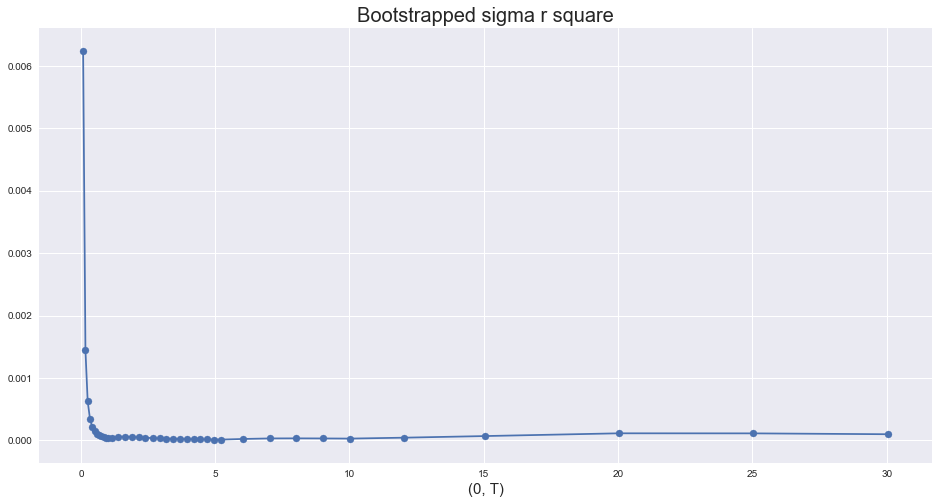

In [19]:
# 視覺化
start_index = 0

plt.figure(figsize=(16, 8), facecolor='white')
plt.plot(
    bootstrapped_sigma_r_square_result['T'].iloc[start_index:,],
    bootstrapped_sigma_r_square_result['sigma_r_square'].iloc[start_index:,]
)
plt.scatter(
    bootstrapped_sigma_r_square_result['T'].iloc[start_index:,],
    bootstrapped_sigma_r_square_result['sigma_r_square'].iloc[start_index:,]
)

if start_index > 0:
    title = 'Bootstrapped sigma r square (drop first {} value)'.format(start_index)
else:
    title = 'Bootstrapped sigma r square'
plt.title(title, fontsize=20)
plt.xlabel('(0, T)', fontsize=15);

# 對sigma_s_square進行bootstrap
由於日期只有1M的期貨對的起來，因此目前只先針對1M的去估，後面的值再用NSS估出來

In [20]:
bootstrapped_sigma_s_square_collection = {}
bootstrapped_sigma_s_square_collection[(1/12)] = initial_sigma_s_square

In [21]:
# 找出1M, 3M SOFR futures有資料的對應區間，選至5.205600年(前29個值)，且要drop掉1.141667年(index=12的地方)
Fed_Fund_rate_collection_for_sigma_s_square_estimation = Fed_Fund_rate_collection[:29].drop(
    index=12
)

# 把sigma_s_square_collection中要使用到的值合併回去Fed_Fund_rate_collection_for_sigma_s_square_estimation
# 這裡確認Fed_Fund_rate_collection_for_sigma_s_square_estimation的Tenor已經與Fed_Fund_rate_collection一致
# 所以就沒有用merge的方式了，而是直接寫入
Fed_Fund_rate_collection_for_sigma_s_square_estimation = Fed_Fund_rate_collection_for_sigma_s_square_estimation.copy()
for column_name in ['T1', 'T2', 'Type of futures', 'SOFR futures rate']:
    Fed_Fund_rate_collection_for_sigma_s_square_estimation[
        column_name
    ] = sigma_s_square_collection[column_name].values
# 最後要reset_index下方for loop才不會有問題，因為會依據index拿值  
Fed_Fund_rate_collection_for_sigma_s_square_estimation.reset_index(inplace=True, drop=True)

In [22]:
# 檢查Required Tenor是否等於T2，看有沒有對齊
Fed_Fund_rate_collection_for_sigma_s_square_estimation

,Required Tenor,Discount factor,Zero_Rate_Cubic_spline,T1,T2,Type of futures,SOFR futures rate
0,0.083333,0.998659,0.016100,0.011111,0.083333,1,0.01590
1,0.169444,0.997285,0.016044,0.083333,0.169444,1,0.01560
2,0.252778,0.995976,0.015950,0.169444,0.252778,1,0.01535
3,0.338889,0.994653,0.015822,0.252778,0.338889,1,0.01480
4,0.422222,0.993419,0.015637,0.338889,0.422222,1,0.01435
5,0.508333,0.992164,0.015475,0.422222,0.508333,1,0.01395
6,0.594444,0.990959,0.015278,0.508333,0.594444,1,0.01340
7,0.677778,0.989839,0.015068,0.594444,0.677778,1,0.01305
8,0.763889,0.988704,0.014872,0.677778,0.763889,1,0.01250
9,0.847222,0.987672,0.014641,0.763889,0.847222,1,0.01210


In [23]:
def B(T):
    return (1 - np.exp(-k * T)) / k

def sigma_s_square_bootstrap_function(
    X,
    sigma_s_square
):
    short_T, long_T, current_phi_T, current_SORF_rate = X
    print('short_T: {}'.format(short_T))
    print('long_T: {}'.format(long_T))
    print('current_phi_T: {}'.format(current_phi_T))
    print('current_SORF_rate: {}'.format(current_SORF_rate))
    print('sigma_s_square_short_T: {}'.format(
        bootstrapped_sigma_s_square_collection[short_T]
    ))
    print('')
    
    return (
        np.exp(
            -current_phi_T
        ) *
        np.exp(
            -theta * (
                (long_T - short_T) + (np.exp(-k * long_T) - np.exp(-k * short_T))/k
            )
        ) * np.exp(
            0.5*(
                (
                    (sigma_s_square * (long_T ** 3) / 3) - 
                    (bootstrapped_sigma_s_square_collection[short_T] * (short_T ** 3) / 3)
                ) +
                (
                   (bootstrapped_sigma_r_square_collection[long_T] / (k**2)) * (
                       long_T - B(long_T) - (k * (B(long_T)**2) / 2)
                   ) -
                   (bootstrapped_sigma_r_square_collection[short_T] / (k**2)) * (
                       short_T - B(short_T) - (k * (B(short_T)**2) / 2)
                   )
                ) +
                (
                    (2 * rho / k) * (
                        (sigma_s_square ** 0.5) * 
                        (bootstrapped_sigma_r_square_collection[long_T] ** 0.5) *
                        (
                            ((long_T ** 2) / 2) -
                            (1/k + long_T) * B(long_T) +
                            (long_T / k)
                        ) - 
                        (bootstrapped_sigma_s_square_collection[short_T] ** 0.5) * 
                        (bootstrapped_sigma_r_square_collection[short_T] ** 0.5) *
                        (
                            ((short_T ** 2) / 2) -
                            (1/k + short_T) * B(short_T) +
                            (short_T / k)
                        )
                    )
                )
            )
        ) * (
            1 + current_SORF_rate * (long_T - short_T)
        )
    ) - 1

In [24]:
def validate_bootstrapped_sigma_s_square(bootstrapped_sigma_s_square):
    return (
        np.exp(
            -current_phi_T
        ) *
        np.exp(
            -theta * (
                (long_T - short_T) + (np.exp(-k * long_T) - np.exp(-k * short_T))/k
            )
        ) * np.exp(
            0.5*(
                (
                    (bootstrapped_sigma_s_square * (long_T ** 3) / 3) - 
                    (bootstrapped_sigma_s_square_collection[short_T] * (short_T ** 3) / 3)
                ) +
                (
                   (bootstrapped_sigma_r_square_collection[long_T] / (k**2)) * (
                       long_T - B(long_T) - (k * (B(long_T)**2) / 2)
                   ) -
                   (bootstrapped_sigma_r_square_collection[short_T] / (k**2)) * (
                       short_T - B(short_T) - (k * (B(short_T)**2) / 2)
                   )
                ) +
                (
                    (2 * rho / k) * (
                        (bootstrapped_sigma_s_square ** 0.5) * 
                        (bootstrapped_sigma_r_square_collection[long_T] ** 0.5) *
                        (
                            (long_T ** 2) / 2 -
                            (1/k + long_T) * B(long_T) +
                            (long_T / k)
                        ) - 
                        (bootstrapped_sigma_s_square_collection[short_T] ** 0.5) * 
                        (bootstrapped_sigma_r_square_collection[short_T] ** 0.5) *
                        (
                            (short_T ** 2) / 2 -
                            (1/k + short_T) * B(short_T) +
                            (short_T / k)
                        )
                    )
                )
            )
        )
    )

In [25]:
for i in range(len(Fed_Fund_rate_collection_for_sigma_s_square_estimation)-1):
    # 指定好T，之後都會依據此T去抓點對應的值
    short_T = Fed_Fund_rate_collection_for_sigma_s_square_estimation['Required Tenor'][i]
    long_T = Fed_Fund_rate_collection_for_sigma_s_square_estimation['Required Tenor'][i+1]

    # 找出對應的phi_T
    current_phi_T = phi_T_collection[
        round(phi_T_collection['Required Tenor'], 3) == round(long_T, 3)
    ]['phi(T1, T2)'].values[0]

    # 指定對應的k star
    current_SORF_rate = Fed_Fund_rate_collection_for_sigma_s_square_estimation[
        Fed_Fund_rate_collection_for_sigma_s_square_estimation['Required Tenor'] == long_T
    ]['SOFR futures rate'].values[0]
    
    
    popt, pcov = curve_fit(
        sigma_s_square_bootstrap_function,
        [short_T, long_T, current_phi_T, current_SORF_rate],
        0,
        maxfev=500000
    )

    bootstrapped_sigma_s_square_collection[long_T] = popt[0]
    
    print('Difference: {}'.format((
        validate_bootstrapped_sigma_s_square(popt[0]) -
        (1 / (1 + current_SORF_rate * (long_T - short_T)))
    )))
    
    print('')
    print('=========================================')
    print('')

short_T: 0.08333333333333333
long_T: 0.16944444444444445
current_phi_T: 0.0013774421642976302
current_SORF_rate: 0.015600000000000001
sigma_s_square_short_T: 0.32225596902218384

short_T: 0.08333333333333333
long_T: 0.16944444444444445
current_phi_T: 0.0013774421642976302
current_SORF_rate: 0.015600000000000001
sigma_s_square_short_T: 0.32225596902218384

short_T: 0.08333333333333333
long_T: 0.16944444444444445
current_phi_T: 0.0013774421642976302
current_SORF_rate: 0.015600000000000001
sigma_s_square_short_T: 0.32225596902218384

short_T: 0.08333333333333333
long_T: 0.16944444444444445
current_phi_T: 0.0013774421642976302
current_SORF_rate: 0.015600000000000001
sigma_s_square_short_T: 0.32225596902218384

short_T: 0.08333333333333333
long_T: 0.16944444444444445
current_phi_T: 0.0013774421642976302
current_SORF_rate: 0.015600000000000001
sigma_s_square_short_T: 0.32225596902218384

short_T: 0.08333333333333333
long_T: 0.16944444444444445
current_phi_T: 0.0013774421642976302
current_SOR

/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars



long_T: 3.1638888888888888
current_phi_T: 0.0026195583591097425
current_SORF_rate: 0.010700000000000001
sigma_s_square_short_T: 0.00039308399326224433

short_T: 2.930555555555556
long_T: 3.1638888888888888
current_phi_T: 0.0026195583591097425
current_SORF_rate: 0.010700000000000001
sigma_s_square_short_T: 0.00039308399326224433

short_T: 2.930555555555556
long_T: 3.1638888888888888
current_phi_T: 0.0026195583591097425
current_SORF_rate: 0.010700000000000001
sigma_s_square_short_T: 0.00039308399326224433

short_T: 2.930555555555556
long_T: 3.1638888888888888
current_phi_T: 0.0026195583591097425
current_SORF_rate: 0.010700000000000001
sigma_s_square_short_T: 0.00039308399326224433

short_T: 2.930555555555556
long_T: 3.1638888888888888
current_phi_T: 0.0026195583591097425
current_SORF_rate: 0.010700000000000001
sigma_s_square_short_T: 0.00039308399326224433

short_T: 2.930555555555556
long_T: 3.1638888888888888
current_phi_T: 0.0026195583591097425
current_SORF_rate: 0.010700000000000001


short_T: 4.194444444444445
long_T: 4.447222222222221
current_phi_T: 0.003003831228632259
current_SORF_rate: 0.01095
sigma_s_square_short_T: 0.00024174389653016182

short_T: 4.194444444444445
long_T: 4.447222222222221
current_phi_T: 0.003003831228632259
current_SORF_rate: 0.01095
sigma_s_square_short_T: 0.00024174389653016182

short_T: 4.194444444444445
long_T: 4.447222222222221
current_phi_T: 0.003003831228632259
current_SORF_rate: 0.01095
sigma_s_square_short_T: 0.00024174389653016182

short_T: 4.194444444444445
long_T: 4.447222222222221
current_phi_T: 0.003003831228632259
current_SORF_rate: 0.01095
sigma_s_square_short_T: 0.00024174389653016182

short_T: 4.194444444444445
long_T: 4.447222222222221
current_phi_T: 0.003003831228632259
current_SORF_rate: 0.01095
sigma_s_square_short_T: 0.00024174389653016182

short_T: 4.194444444444445
long_T: 4.447222222222221
current_phi_T: 0.003003831228632259
current_SORF_rate: 0.01095
sigma_s_square_short_T: 0.00024174389653016182

short_T: 4.19444

In [26]:
# 把結果存成另外一個Dataframe，因為後面估sigma_s_square還是需要用到dict
bootstrapped_sigma_s_square_result = pd.DataFrame([bootstrapped_sigma_s_square_collection]).T
bootstrapped_sigma_s_square_result.reset_index(inplace=True)
bootstrapped_sigma_s_square_result.columns = ['T', 'sigma_s_square']

In [27]:
# bootstrapped_sigma_s_square_result.to_excel(
#     'bootstrapped_sigma_s_square_result.xlsx', index=False
# )

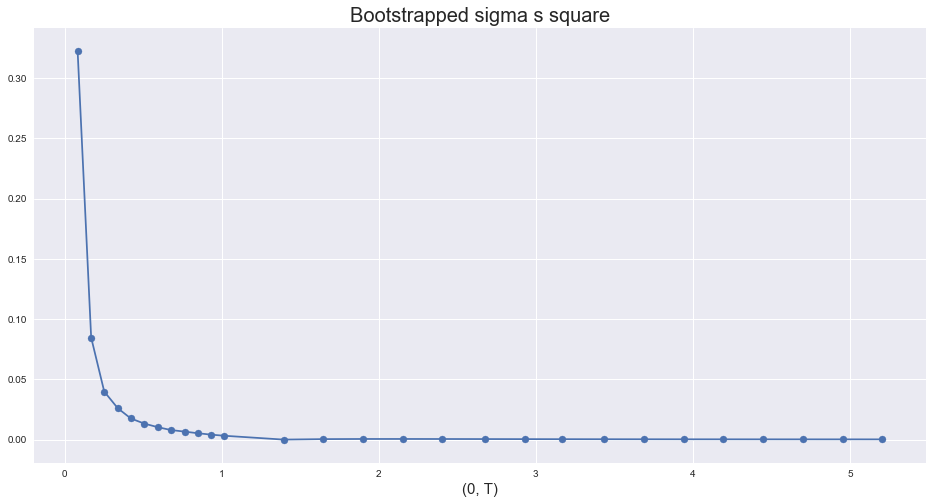

In [28]:
# 視覺化
start_index = 0

plt.figure(figsize=(16, 8), facecolor='white')
plt.plot(
    bootstrapped_sigma_s_square_result['T'].iloc[start_index:,],
    bootstrapped_sigma_s_square_result['sigma_s_square'].iloc[start_index:,]
)
plt.scatter(
    bootstrapped_sigma_s_square_result['T'].iloc[start_index:,],
    bootstrapped_sigma_s_square_result['sigma_s_square'].iloc[start_index:,]
)

plt.title('Bootstrapped sigma s square', fontsize=20)
plt.xlabel('(0, T)', fontsize=15);

# 將R(0, T畫出來)

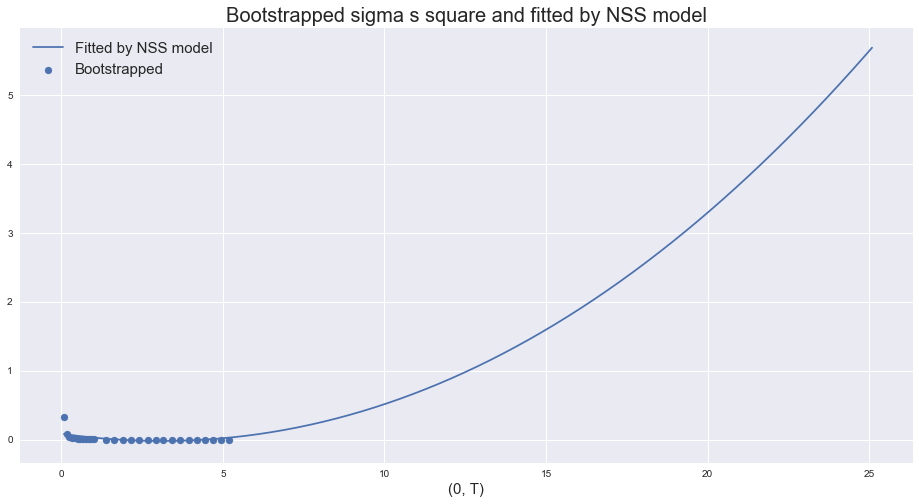

In [29]:
# 把sigma_s_square用NSS連起來，目前只有~1年的點
# Nelson-Siegel-Svensson Approach
def function_NSS(t, B_0, B_1, B_2, B_3, theta_NSS, vega):
    return (
        B_0 +
        B_1 * ((1 - np.exp(-t/theta_NSS)) / (t/theta_NSS)) +
        B_2 * (((1 - np.exp(-t/theta_NSS)) / (t/theta_NSS)) - np.exp(-t/theta_NSS)) +
        B_3 * (((1 - np.exp(-t/vega)) / (t/vega)) - np.exp(-t/vega))
    )

popt_NSS_sigma_s_square, pcov_NSS_sigma_s_square = curve_fit(
    function_NSS,
    bootstrapped_sigma_s_square_result['T'],
    bootstrapped_sigma_s_square_result['sigma_s_square'],
    maxfev=50000
)

T = np.arange(1/12, 25.1, 0.1)

plt.figure(figsize=(16, 8), facecolor='white')
plt.plot(T, function_NSS(T, *popt_NSS_sigma_s_square), label='Fitted by NSS model')
plt.scatter(
    bootstrapped_sigma_s_square_result['T'],
    bootstrapped_sigma_s_square_result['sigma_s_square'],
    label='Bootstrapped'
)

plt.title('Bootstrapped sigma s square and fitted by NSS model', fontsize=20)
plt.xlabel('(0, T)', fontsize=15)
plt.legend(fontsize=15);

上述步驟是要將sigma_s_square透過NSS把五年後的值也fit出來，但是以下有發現NSS出來的sigma_s_square會有小於0的情況，帶入R(0, T)裡面會有sigma_s_square需要開根號的時候就會出現na，和老師討論之後，目前不透過NSS把sigma_s_square後五年的值fit出來，到時會改成自己帶入

(且之前也有發現用fit出來的sigma_s_square會有讓R(0, T)發散的問題)。

In [30]:
# 先把所有所需的參數都串起來
# 先將Fed_Fund_rate, phi_T, bootstrapped_sigma_r_square,都建立一個key_for_merge避免浮點數的問題
Fed_Fund_rate_collection['key_for_merge'] = round(
    Fed_Fund_rate_collection['Required Tenor'], 5
)

# 積分值需要衡量0~T_2的區間，先前都是一段一段的，因此這裡要累加才會是0~T_2的積分值
# 這裡針對phi(T1, T2)先進行cumsum，因為之後merge完一開始0.0111年的部分會被drop掉
# 如果在此步驟之後才cumsum會有問題，會漏掉0.111年的結果，因此要先在merge前就cumsum
phi_T_collection['key_for_merge'] = round(
    phi_T_collection['Required Tenor'], 5
)
phi_T_collection['phi(T1, T2)'] = phi_T_collection['phi(T1, T2)'].cumsum()

bootstrapped_sigma_r_square_result['key_for_merge'] = round(
    bootstrapped_sigma_r_square_result['T'], 5
)

# 接著以Fed_Fund_rate為主將其他表串起來
# 雖然之前在Tenor: 1.141667會有需要drop掉的問題，但那是在估計sigma_s_square時才會有的問題(因為沒有對應的k*)
# 且之前估計sigma_s_square都沒有直接將原始Fed_Fund_rate的Tenor: 1.141667drop掉
# 而是另外建立一個複製的Fed_Fund_rate才drop掉，因此Fed_Fund_rate原始檔案還是有Tenor: 1.141667

# 先看一下原始Fed_Fund_rate有多少筆資料，用以判斷merge後是否有掉資料問題(浮點數問題)
print(len(Fed_Fund_rate_collection))

# 合併三個資料，並將其指定為parameters_collection
parameters_collection = Fed_Fund_rate_collection.merge(
    phi_T_collection, on='key_for_merge'
).merge(
    bootstrapped_sigma_r_square_result, on='key_for_merge'
)

# 檢查merge後的資料筆數，確認沒有掉資料，與merge前相同
print(len(parameters_collection))

39
39


In [31]:
# 看一下合併後的結果
# Required Tenor_x, Required Tenor_y，後面出現x, y代表在merge時資料本身同時都有Required Tenor此欄位
# 而merge是以key_for_megre為key進行，所以其他重複欄位名稱會自動被加上_x, _y，底下會再把重複欄位drop掉
parameters_collection

,Required Tenor_x,Discount factor,Zero_Rate_Cubic_spline,key_for_merge,Required Tenor_y,"phi(T1, T2)",T,sigma_r_square
0,0.083333,0.998659,0.016100,0.08333,0.083333,0.001342,0.083333,0.006235
1,0.169444,0.997285,0.016044,0.16944,0.169444,0.002719,0.169444,0.001442
2,0.252778,0.995976,0.015950,0.25278,0.252778,0.004033,0.252778,0.000626
3,0.338889,0.994653,0.015822,0.33889,0.338889,0.005364,0.338889,0.000343
4,0.422222,0.993419,0.015637,0.42222,0.422222,0.006605,0.422222,0.000216
5,0.508333,0.992164,0.015475,0.50833,0.508333,0.007869,0.508333,0.000148
6,0.594444,0.990959,0.015278,0.59444,0.594444,0.009085,0.594444,0.000108
7,0.677778,0.989839,0.015068,0.67778,0.677778,0.010217,0.677778,0.000082
8,0.763889,0.988704,0.014872,0.76389,0.763889,0.011365,0.763889,0.000064
9,0.847222,0.987672,0.014641,0.84722,0.847222,0.012409,0.847222,0.000052


In [32]:
# 到了這一步驟才將sigma_s_square merge進來，原本要透過NSS model直接取值，但現在直接用bootstrap的結果
bootstrapped_sigma_s_square_result['key_for_merge'] = round(
    bootstrapped_sigma_s_square_result['T'], 5
)

# 併入上述parameters_collection，這裡改採用outer的方式，之前預設都是inner
# 主要差異在於之前的表格Tenor都是完整的所以對的起來，用inner也不會有掉值的問題
# (只有phi(T1, T2)中會有0.011111的Tenor會自動被drop掉，但因為本來就不需要此Tenor所以不影響)
# 而sigma_s_square由於只有前5年的值，所以要用outer才不會使其他表格資料被drop掉
parameters_collection = parameters_collection.merge(
    bootstrapped_sigma_s_square_result,
    on='key_for_merge',
    how='outer'
)

In [33]:
# 看一下當前表格，多了T_y此需要drop掉的欄位
parameters_collection

,Required Tenor_x,Discount factor,Zero_Rate_Cubic_spline,key_for_merge,Required Tenor_y,"phi(T1, T2)",T_x,sigma_r_square,T_y,sigma_s_square
0,0.083333,0.998659,0.016100,0.08333,0.083333,0.001342,0.083333,0.006235,0.083333,0.322256
1,0.169444,0.997285,0.016044,0.16944,0.169444,0.002719,0.169444,0.001442,0.169444,0.084692
2,0.252778,0.995976,0.015950,0.25278,0.252778,0.004033,0.252778,0.000626,0.252778,0.039833
3,0.338889,0.994653,0.015822,0.33889,0.338889,0.005364,0.338889,0.000343,0.338889,0.026032
4,0.422222,0.993419,0.015637,0.42222,0.422222,0.006605,0.422222,0.000216,0.422222,0.017508
5,0.508333,0.992164,0.015475,0.50833,0.508333,0.007869,0.508333,0.000148,0.508333,0.013250
6,0.594444,0.990959,0.015278,0.59444,0.594444,0.009085,0.594444,0.000108,0.594444,0.010277
7,0.677778,0.989839,0.015068,0.67778,0.677778,0.010217,0.677778,0.000082,0.677778,0.007927
8,0.763889,0.988704,0.014872,0.76389,0.763889,0.011365,0.763889,0.000064,0.763889,0.006628
9,0.847222,0.987672,0.014641,0.84722,0.847222,0.012409,0.847222,0.000052,0.847222,0.005300


In [34]:
# drop重複的欄位
parameters_collection.drop(
    columns=['key_for_merge', 'Required Tenor_y', 'T_x', 'T_y'], inplace=True
)

# 重新命名
parameters_collection.rename(columns={'Required Tenor_x': 'Required Tenor'}, inplace=True)

# 先建立空值等等裝結果
parameters_collection['R_T'] = None

# 看一下最終合併後的結果
parameters_collection

,Required Tenor,Discount factor,Zero_Rate_Cubic_spline,"phi(T1, T2)",sigma_r_square,sigma_s_square,R_T
0,0.083333,0.998659,0.016100,0.001342,0.006235,0.322256,None
1,0.169444,0.997285,0.016044,0.002719,0.001442,0.084692,None
2,0.252778,0.995976,0.015950,0.004033,0.000626,0.039833,None
3,0.338889,0.994653,0.015822,0.005364,0.000343,0.026032,None
4,0.422222,0.993419,0.015637,0.006605,0.000216,0.017508,None
5,0.508333,0.992164,0.015475,0.007869,0.000148,0.013250,None
6,0.594444,0.990959,0.015278,0.009085,0.000108,0.010277,None
7,0.677778,0.989839,0.015068,0.010217,0.000082,0.007927,None
8,0.763889,0.988704,0.014872,0.011365,0.000064,0.006628,None
9,0.847222,0.987672,0.014641,0.012409,0.000052,0.005300,None


In [35]:
def R_T(T, sigma_r_square, sigma_s_square, phi_T):
    print('T: {}'.format(T))
    print('sigma_r_square: {}'.format(sigma_r_square))
    print('sigma_s_square: {}'.format(sigma_s_square))
    print('phi_T: {}'.format(phi_T))
    
    return (1/T) * (
        (theta * (T - B(T))) +
        phi_T -
        0.5 * (
            (sigma_s_square * (T**3) / 3) +
            (
                (sigma_r_square / (k**2)) *
                (T - B(T) - (k/2) * (B(T)**2))
            ) +
            (2 * rho * (sigma_s_square ** 0.5) * (sigma_r_square ** 0.5) / k) * (
                (T**2) / 2 -
                ((1/k) + T) * B(T) +
                (T/k)
            )
        )
    )

In [36]:
for i in range(len(parameters_collection)):
    T = parameters_collection.iloc[i]['Required Tenor']
    sigma_r_square = parameters_collection.iloc[i]['sigma_r_square']
    sigma_s_square = parameters_collection.iloc[i]['sigma_s_square']
    phi_T = parameters_collection.iloc[i]['phi(T1, T2)']
    
    current_R_T = R_T(
        T, sigma_r_square, sigma_s_square, phi_T
    )
    
    parameters_collection.loc[i, 'R_T'] = current_R_T 
    print('R_T: {}'.format(current_R_T ))
    
    
    print('')
    print('=========================================')
    print('')

T: 0.08333333333333333
sigma_r_square: 0.00623488457694546
sigma_s_square: 0.32225596902218384
phi_T: 0.001342042339187034
R_T: 0.01575151828521174


T: 0.16944444444444445
sigma_r_square: 0.0014421948095025077
sigma_s_square: 0.08469204081303944
phi_T: 0.002719484503484664
R_T: 0.01566919706813322


T: 0.25277777777777777
sigma_r_square: 0.0006259024069396362
sigma_s_square: 0.039832684292630385
phi_T: 0.004033159459852331
R_T: 0.015560733450082898


T: 0.33888888888888896
sigma_r_square: 0.0003426832983386932
sigma_s_square: 0.026032197165921696
phi_T: 0.0053637888644321695
R_T: 0.01536503798820016


T: 0.4222222222222222
sigma_r_square: 0.00021611410110281248
sigma_s_square: 0.01750833356093421
phi_T: 0.006604781325440151
R_T: 0.015163009450388528


T: 0.5083333333333333
sigma_r_square: 0.00014847488381332437
sigma_s_square: 0.013249566764756372
phi_T: 0.007869480446854295
R_T: 0.0149561087650232


T: 0.5944444444444444
sigma_r_square: 0.00010794429062201047
sigma_s_square: 0.010276

Text(0.5, 1.0, 'Fed Fund rate vs. R(0, T)')

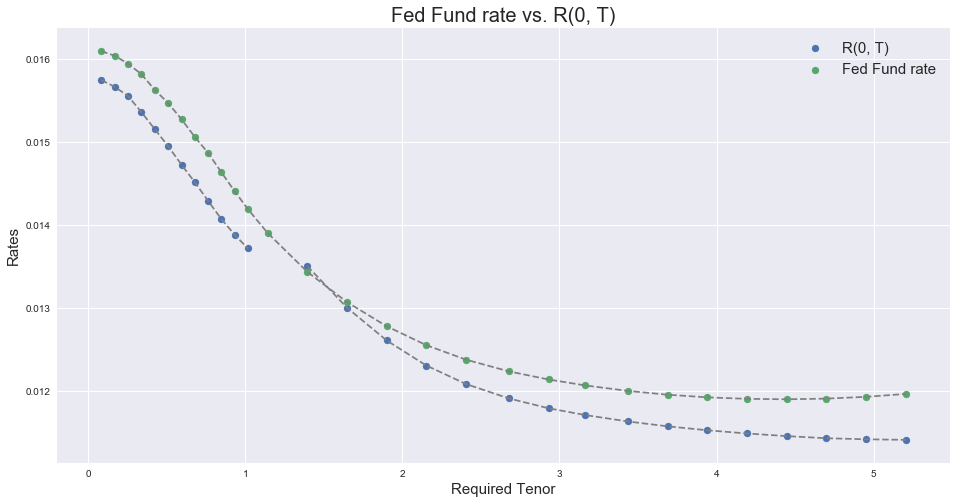

In [37]:
# 先看看5年內的結果，目前也只有5年內計算得出值，5年後R(0, T)為na
parameters_collection_for_plot = parameters_collection[
    parameters_collection['Required Tenor'] < 5.5
]

plt.figure(figsize=(16, 8), facecolor='white')

plt.plot(
    parameters_collection_for_plot['Required Tenor'],
    parameters_collection_for_plot.R_T,
    color='grey',
    ls='--'
)

plt.scatter(
    parameters_collection_for_plot['Required Tenor'],
    parameters_collection_for_plot.R_T,
    label='R(0, T)'
)

plt.plot(
    parameters_collection_for_plot['Required Tenor'],
    parameters_collection_for_plot['Zero_Rate_Cubic_spline'],
    color='grey',
    ls='--'
)

plt.scatter(
    parameters_collection_for_plot['Required Tenor'],
    parameters_collection_for_plot['Zero_Rate_Cubic_spline'],
    label='Fed Fund rate'
)


plt.xlabel('Required Tenor', fontsize=15)
plt.ylabel('Rates', fontsize=15)
plt.legend(fontsize=15)
plt.title('Fed Fund rate vs. R(0, T)', fontsize=20)

# plt.ylim(0.011, 0.0155);

In [38]:
# 避免混淆針對以上幾個欄位重新命名
# phi(T1, T2)已經經過累積加總所以會是phi(0, T)
# sigma_r_square, sigma_s_square是bootstrapped結果，所以前面加上bootstrapped
# 同時儲存結果，這樣就不會改到原先檔案欄位，以下code就不必更改
parameters_collection.rename(
    columns={
        'phi(T1, T2)': 'phi(0, T)',
        'sigma_r_square': 'bootstrapped_sigma_r_square',
        'sigma_s_square': 'bootstrapped_sigma_s_square'
    }
).to_csv('bootstrapped sigma_r_square & sigma_s_square.csv', index=False)

# 試看看對五年後sigma_s_square補不同值的結果

In [39]:
# 建立一個複製的資料，不直接更改舊的
temp_parameters_collection = parameters_collection.copy()

# 試看看補0，中間會有一段1.1417的Tenor也有na，這樣做也會補0
temp_parameters_collection.sigma_s_square.fillna(0, inplace=True)

In [40]:
for i in range(len(temp_parameters_collection)):
    T = temp_parameters_collection.iloc[i]['Required Tenor']
    sigma_r_square = temp_parameters_collection.iloc[i]['sigma_r_square']
    sigma_s_square = temp_parameters_collection.iloc[i]['sigma_s_square']
    phi_T = temp_parameters_collection.iloc[i]['phi(T1, T2)']
    
    current_R_T = R_T(
        T, sigma_r_square, sigma_s_square, phi_T
    )
    
    temp_parameters_collection.loc[i, 'R_T'] = current_R_T 
    print('R_T: {}'.format(current_R_T ))
    
    
    print('')
    print('=========================================')
    print('')

T: 0.08333333333333333
sigma_r_square: 0.00623488457694546
sigma_s_square: 0.32225596902218384
phi_T: 0.001342042339187034
R_T: 0.01575151828521174


T: 0.16944444444444445
sigma_r_square: 0.0014421948095025077
sigma_s_square: 0.08469204081303944
phi_T: 0.002719484503484664
R_T: 0.01566919706813322


T: 0.25277777777777777
sigma_r_square: 0.0006259024069396362
sigma_s_square: 0.039832684292630385
phi_T: 0.004033159459852331
R_T: 0.015560733450082898


T: 0.33888888888888896
sigma_r_square: 0.0003426832983386932
sigma_s_square: 0.026032197165921696
phi_T: 0.0053637888644321695
R_T: 0.01536503798820016


T: 0.4222222222222222
sigma_r_square: 0.00021611410110281248
sigma_s_square: 0.01750833356093421
phi_T: 0.006604781325440151
R_T: 0.015163009450388528


T: 0.5083333333333333
sigma_r_square: 0.00014847488381332437
sigma_s_square: 0.013249566764756372
phi_T: 0.007869480446854295
R_T: 0.0149561087650232


T: 0.5944444444444444
sigma_r_square: 0.00010794429062201047
sigma_s_square: 0.010276

Text(0.5, 1.0, 'Fed Fund rate vs. R(0, T)')

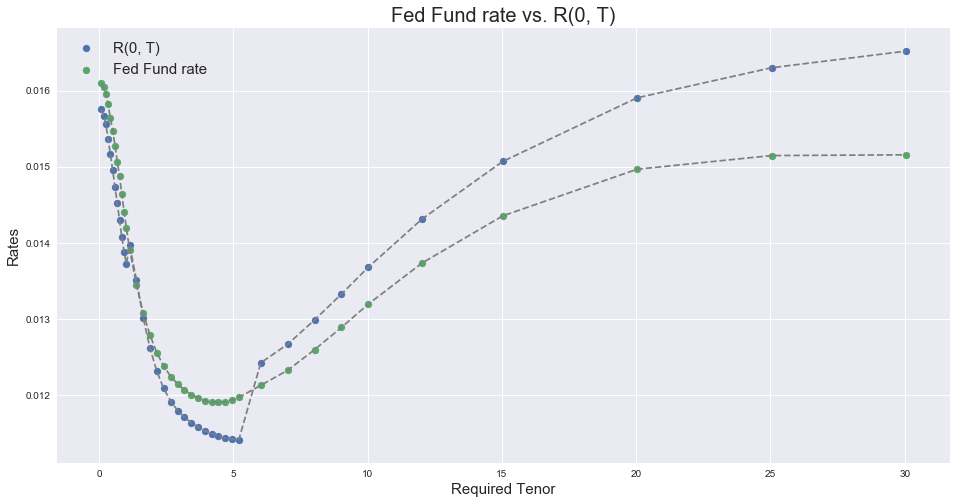

In [41]:
plt.figure(figsize=(16, 8), facecolor='white')

plt.plot(
    temp_parameters_collection['Required Tenor'],
    temp_parameters_collection.R_T,
    color='grey',
    ls='--'
)

plt.scatter(
    temp_parameters_collection['Required Tenor'],
    temp_parameters_collection.R_T,
    label='R(0, T)'
)

plt.plot(
    temp_parameters_collection['Required Tenor'],
    temp_parameters_collection['Zero_Rate_Cubic_spline'],
    color='grey',
    ls='--'
)

plt.scatter(
    temp_parameters_collection['Required Tenor'],
    temp_parameters_collection['Zero_Rate_Cubic_spline'],
    label='Fed Fund rate'
)


plt.xlabel('Required Tenor', fontsize=15)
plt.ylabel('Rates', fontsize=15)
plt.legend(fontsize=15)
plt.title('Fed Fund rate vs. R(0, T)', fontsize=20)

# plt.ylim(0.011, 0.0155);

# 有兩種方式可以去估：fsolve, curve fit
# 以上sigma_r_square是使用fsolve；sigma_s_square是使用curve_fit，以下則附上反過來的方法
發現估sigma r square時使用fsolve沒問題，但在估sigma s square時使用f solve會估不出來但改用curve fit就可以，因此有回頭測試sigma r square使用curve fit去估發現前面都沒問題且會和用fsolve估出來的一樣，但是最後兩個值估的時候會估不出來。

上述原因就沒有去細究了，但sigma r square就用fsolve, sigma s square就用curve fit，推測fsolve是forㄧ元一次，因為sigma r square在公式中只出現一次，但sigma s square有包在根號裡的，也有單獨一次的，所以可能會變ㄧ元二次，因此fsovle會無法使用。

用curve fit估sigma r square

In [42]:
# def sigma_r_square_bootstrap_function(X, sigma_r_square):
#     short_T, long_T, current_phi_T, P_short_T, P_long_T = X
#     return (
#         np.exp(-current_phi_T) * (
#             (
#                 np.exp(
#                     (0.5 * sigma_r_square / k**2) * (
#                         long_T - 
#                         (2/k) * (1 - np.exp(-k * long_T)) +
#                         (1/(2*k)) * (1 - np.exp(-2 * k * long_T))
#                     )
#                 )
#             ) / (
#                 np.exp(
#                     (0.5 * bootstrapped_sigma_r_square_collection[short_T] / k**2) * (
#                         short_T - 
#                         (2/k) * (1 - np.exp(-k * short_T)) +
#                         (1/(2*k)) * (1 - np.exp(-2 * k * short_T))
#                     )
#                 )
#             )
#         ) * (
#             P_short_T / P_long_T
#         )
#     ) -1

In [43]:
# for i in range(len(Fed_Fund_rate_collection)-1):
#     # 指定好T，之後都會依據此T去抓點對應的值
#     short_T = Fed_Fund_rate_collection.index[i]
#     long_T = Fed_Fund_rate_collection.index[i+1]

#     # 找出對應的phi_T
#     current_phi_T = phi_T_collection[
#         round(phi_T_collection.T_1, 5) == round(short_T, 5)
#     ]['phi_t_after_log'].values[0]

#     # 找出對應的P
#     P_short_T = Fed_Fund_rate_collection[
#         Fed_Fund_rate_collection.index == short_T
#     ]['Discount factor'].values[0]

#     P_long_T = Fed_Fund_rate_collection[
#         Fed_Fund_rate_collection.index == long_T
#     ]['Discount factor'].values[0]
    
#     popt, pcov = curve_fit(
#         sigma_r_square_bootstrap_function,
#         [short_T, long_T, current_phi_T, P_short_T, P_long_T],
#         0,
#         maxfev=500000
#     )

#     bootstrapped_sigma_r_square_collection[long_T] = popt[0]
    
#     print('Difference: {}'.format((
#         validate_bootstrapped_sigma_r_square(popt[0]) -
#         (P_long_T / P_short_T )
#     )))

In [44]:
# # 把結果存成另外一個Dataframe，因為後面估sigma_s_square還是需要用到dict
# bootstrapped_sigma_r_square_result = pd.DataFrame([bootstrapped_sigma_r_square_collection]).T
# bootstrapped_sigma_r_square_result.reset_index(inplace=True)
# bootstrapped_sigma_r_square_result.columns = ['T', 'sigma_r_square']

In [45]:
# # 視覺化
# start_index = 3
# end_index = -2

# plt.figure(figsize=(16, 8), facecolor='white')
# plt.plot(
#     bootstrapped_sigma_r_square_result['T'].iloc[start_index: end_index,],
#     bootstrapped_sigma_r_square_result['sigma_r_square'].iloc[start_index: end_index,]
# )
# plt.scatter(
#     bootstrapped_sigma_r_square_result['T'].iloc[start_index: end_index,],
#     bootstrapped_sigma_r_square_result['sigma_r_square'].iloc[start_index: end_index,]
# )

# plt.title('Bootstrapped sigma s square', fontsize=20);

用fsolve估sigma s square

In [46]:
# def B(T):
#     return (1 - np.exp(-k * T)) / k

# def sigma_s_square_bootstrap_function(sigma_s_square):
#     return (
#         np.exp(
#             -current_phi_T
#         ) *
#         np.exp(
#             -theta * (
#                 (long_T - short_T) - (np.exp(-k * long_T) - np.exp(-k * short_T))/k
#             )
#         ) * np.exp(
#             0.5*(
#                 (
#                     (sigma_s_square * (long_T ** 3) / 3) - 
#                     (bootstrapped_sigma_s_square_collection[short_T] * (short_T ** 3) / 3)
#                 ) +
#                 (
#                    (bootstrapped_sigma_r_square_collection[long_T] / (k**2)) * (
#                        long_T - B(long_T) - (k * (B(long_T)**2) / 2)
#                    ) -
#                    (bootstrapped_sigma_r_square_collection[short_T] / (k**2)) * (
#                        short_T - B(short_T) - (k * (B(short_T)**2) / 2)
#                    )
#                 ) +
#                 (
#                     (2 * rho / k) * (
#                         (sigma_s_square ** 0.5) * 
#                         (bootstrapped_sigma_r_square_collection[long_T] ** 0.5) *
#                         (
#                             ((long_T ** 2) / 2) -
#                             (1/k + long_T) * B(long_T) +
#                             (long_T / k)
#                         ) - 
#                         (bootstrapped_sigma_s_square_collection[short_T] ** 0.5) * 
#                         (bootstrapped_sigma_r_square_collection[short_T] ** 0.5) *
#                         (
#                             ((short_T ** 2) / 2) -
#                             (1/k + short_T) * B(short_T) +
#                             (short_T / k)
#                         )
#                     )
#                 )
#             )
#         ) * (
#             1 + current_SORF_rate * (long_T - short_T)
#         )
#     ) - 1

In [47]:
# for i in range(len(Fed_Fund_rate_collection_for_sigma_s_square_estimation)-1):
#     # 指定好T，之後都會依據此T去抓點對應的值
#     short_T = Fed_Fund_rate_collection_for_sigma_s_square_estimation.index[i]
#     long_T = Fed_Fund_rate_collection_for_sigma_s_square_estimation.index[i+1]

#     # 找出對應的phi_T
#     current_phi_T = phi_T_collection[
#         round(phi_T_collection.T_1, 5) == round(short_T, 5)
#     ]['phi_t_after_log'].values[0]

#     # 指定對應的k star
#     current_SORF_rate = Fed_Fund_rate_collection_for_sigma_s_square_estimation[
#         Fed_Fund_rate_collection_for_sigma_s_square_estimation.index == long_T
#     ]['SOFR futures rate'].values[0]

#     bootstrapped_sigma_s_square = fsolve(sigma_s_square_bootstrap_function, 0)

#     bootstrapped_sigma_s_square_collection[long_T] = bootstrapped_sigma_s_square[0]
    
#     print('Difference: {}'.format((
#         validate_bootstrapped_sigma_s_square(bootstrapped_sigma_s_square) -
#         (1 / (1 + current_SORF_rate * (long_T - short_T)))
#     )[0]))